### 載入所需的Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from typing import List

### 載入資料

In [2]:
# read data from spam.csv
sms_data = pd.read_csv('./D17_spam.csv', usecols = [0,1], encoding = 'latin')
sms_data.columns = ['label', 'content']
print(sms_data.head())

  label                                            content
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
# check how many spams and hams
print(sms_data.groupby('label').count())

       content
label         
ham       4825
spam       747


In [4]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1

sms_data.loc[sms_data.loc[:, 'label'] == 'ham', 'label'] = 0
sms_data.loc[sms_data.loc[:, 'label'] == 'spam', 'label'] = 1
print(sms_data.head())

  label                                            content
0     0  Go until jurong point, crazy.. Available only ...
1     0                      Ok lar... Joking wif u oni...
2     1  Free entry in 2 a wkly comp to win FA Cup fina...
3     0  U dun say so early hor... U c already then say...
4     0  Nah I don't think he goes to usf, he lives aro...


### 切分資料
將資料依據label比例切分為training data與testing data

In [5]:
sms_train, sms_test = train_test_split(sms_data, test_size = 0.2, stratify = sms_data.label)
for sms in [sms_train, sms_test]:
    sms.reset_index(inplace = True, drop = True)
    print(sms.groupby('label').count())

       content
label         
0         3859
1          598
       content
label         
0          966
1          149


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [6]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    for i in range(len(df)):
        # make all content to lowercase
        # remove all punctuations
        df.loc[i, 'content'] = ' '.join([w for w in re.findall(r"[a-zA-Z]*", df.loc[i, 'content'].lower()) if w != ''])
    return df

processed_train = preprocess(sms_train)
processed_test = preprocess(sms_test)

print('Train:\n', processed_train.head())
print('Test: \n', processed_test.head())

Train:
   label                                            content
0     0            are you available for soiree on june rd
1     0  i don t know jack shit about anything or i d s...
2     0  hi do u want to join me with sts later meeting...
3     0  it s ok i noe u re busy but i m really too bor...
4     0  well done blimey exercise yeah i kinda remembe...
Test: 
   label                                            content
0     1  private your account statement for shows un re...
1     0                                           i m done
2     0  yeah so basically any time next week you can g...
3     0  lol i would but my mom would have a fit and te...
4     0                           i send the print outs da


In [7]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
print(len(set(" ".join(list(x_train + x_test)).split())))

7708


### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [8]:
vectorizer = TfidfVectorizer(max_features = 2000)
vectorizer.fit(x_train)
tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print(f'Number of unique word: {len(vectorizer.vocabulary_)}\n')
print(f'tfidf_train:\n{tfidf_train}\n\n')
print(f'tfidf_test:\n{tfidf_test}\n\n')

Number of unique word: 2000

tfidf_train:
  (0, 1990)	0.19363412803336533
  (0, 1354)	0.6248945427573556
  (0, 1188)	0.29301191637220936
  (0, 606)	0.2734048608172129
  (0, 120)	0.5657462341374379
  (0, 94)	0.30222116470814386
  (1, 1990)	0.21258344532255313
  (1, 1897)	0.32810684094336384
  (1, 1861)	0.20418522275571047
  (1, 1733)	0.10346294731271503
  (1, 1689)	0.12598123122878557
  (1, 1687)	0.1577154298572037
  (1, 1676)	0.2096269121938853
  (1, 1558)	0.2494292269741238
  (1, 1497)	0.2780871675193943
  (1, 1447)	0.23881824372338012
  (1, 1203)	0.16935957665963164
  (1, 1025)	0.14520220241882048
  (1, 885)	0.19367235486307308
  (1, 863)	0.17665218440210256
  (1, 806)	0.137251854008412
  (1, 797)	0.17549144100733283
  (1, 457)	0.2189890071426026
  (1, 423)	0.22811326047922167
  (1, 244)	0.16808392441906164
  :	:
  (4456, 1214)	0.15853789106912963
  (4456, 1188)	0.11622207475766816
  (4456, 1175)	0.11324095084569853
  (4456, 1167)	0.1721109030932403
  (4456, 1087)	0.17035222169222808

### 建立共現矩陣

In [9]:
# Function to create co-occurrence matrix
def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    
    # initialize co-occurrence matrix
    vocab_size = len(vocab_list)
    co_matrix = np.zeros(shape=(vocab_size, vocab_size))
    start = time.time()
    
    for idx, sms in enumerate(corpus):
        sms = sms.split()
        sms_ids = [word2idx[word] for word in sms if word in vocab_list] #tokenize
        
        for center_i, center_word_id in enumerate(sms_ids):
            context_ids = sms_ids[max(0, center_i - window_size):center_word_id]
            content_len = len(context_ids)
            
            for left_i, left_word_id in enumerate(context_ids):
                
                if use_weighting:
                    distance = content_len - left_i
                    increment = 1./float(distance)
                else:
                    increment = 1
                    
                co_matrix[center_word_id, left_word_id] += increment
                co_matrix[left_word_id, center_word_id] += increment
        
        if verbose:
            if time.time()-start > 1 or not len(corpus)-(idx+1):
                print(f"{idx+1:<4}/{len(corpus)} is finished.\t",
                      '['+'='*round((idx+1)/len(corpus)*20) + '>' + '.'*(20-round((idx+1)/len(corpus)*20)) + ']',
                      f'{(idx+1)/len(corpus)*100:.2f}%',
                      '' if len(corpus)-(idx+1) else 'Done!')
                start = time.time()
                
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        np.fill_diagonal(co_matrix, 1.)
        
    return co_matrix

co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

print(co_matrix)

2322/4457 is finished.	 [==========>..........] 52.10% 
4457/4457 is finished.	 [====================>] 100.00% Done!
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### 建立PPMI矩陣

In [10]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    start = time.time()

    cnt = 0
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j] + eps))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if time.time()-start > 1 or cnt == total:
                    print(f"{cnt}/{total} is finished.\t",
                          '['+'='*round(cnt/total*20) + '>' + '.'*(20-round(cnt/total*20)) + ']',
                          f'{cnt/total*100:.2f}%',
                          '' if total - cnt else 'Done!')
                    start = time.time()
    return M

ppmi_matrix = ppmi(co_matrix, verbose=True)
print(ppmi_matrix)

208504/4000000 is finished.	 [=>...................] 5.21% 
417966/4000000 is finished.	 [==>..................] 10.45% 
623723/4000000 is finished.	 [===>.................] 15.59% 
827985/4000000 is finished.	 [====>................] 20.70% 
1029632/4000000 is finished.	 [=====>...............] 25.74% 
1233162/4000000 is finished.	 [======>..............] 30.83% 
1440689/4000000 is finished.	 [=======>.............] 36.02% 
1653865/4000000 is finished.	 [========>............] 41.35% 
1858099/4000000 is finished.	 [=========>...........] 46.45% 
2066089/4000000 is finished.	 [==========>..........] 51.65% 
2268112/4000000 is finished.	 [===========>.........] 56.70% 
2473326/4000000 is finished.	 [============>........] 61.83% 
2675475/4000000 is finished.	 [=============>.......] 66.89% 
2877029/4000000 is finished.	 [==============>......] 71.93% 
3081886/4000000 is finished.	 [===============>.....] 77.05% 
3282307/4000000 is finished.	 [================>....] 82.06% 
3492127/40000

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

In [11]:
# Program to find the optimal number of components for Truncated SVD
def svd_fit(matrix, min_variance = 0.98, step = 10, max_n_comp = 2000):
    variance_sum = {} # explained variance ratio for each component of Truncated SVD

    print("Number of components: explained variance")
    for dim in range(int(max_n_comp/step)):# list containing different values of components
        n_comp=(dim+1)*step
        svd = TruncatedSVD(n_components = n_comp)
        svd.fit(matrix)
        variance_sum[n_comp]=(svd.explained_variance_ratio_.sum())
        print(f"{n_comp:^19} : {svd.explained_variance_ratio_.sum():.16f}")
        if svd.explained_variance_ratio_.sum() > min_variance:
            break
    return variance_sum

Number of components: explained variance
        10          : 0.8625707281965956
        20          : 0.8982801898302784
        30          : 0.9163437269113452
        40          : 0.9284850483253807
        50          : 0.9373877614339173
        60          : 0.9445894949725760
        70          : 0.9503801098084328
        80          : 0.9552447108116454
        90          : 0.9593112992260779
        100         : 0.9628033485716392
        110         : 0.9658649698331909
        120         : 0.9685520733704733
        130         : 0.9709613216263718
        140         : 0.9730580110749083
        150         : 0.9749504677649297
        160         : 0.9766574260863924
        170         : 0.9781867797914818
        180         : 0.9795767756322906
        190         : 0.9808194347389869


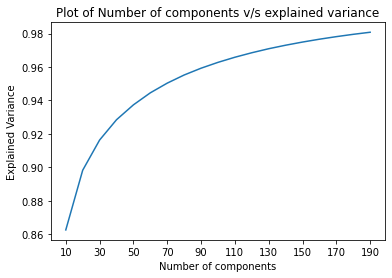

In [12]:
# co-matrix
fit_data_co = svd_fit(co_matrix)

plt.plot(list(fit_data_co), list(fit_data_co.values()))
plt.xlabel('Number of components')
plt.xticks(list(fit_data_co.keys())[::2])
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [13]:
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
# choose 190 as final dimension to reduce to
svd = TruncatedSVD(n_components=list(fit_data_co.keys())[-1])
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)

Number of components: explained variance
        100         : 0.3993382155895233
        200         : 0.5672731399536133
        300         : 0.6676476001739502
        400         : 0.7391121983528137
        500         : 0.7959909439086914
        600         : 0.8418309688568115
        700         : 0.8788012862205505
        800         : 0.9084998369216919
        900         : 0.9322665333747864
       1000         : 0.9510338306427002
       1100         : 0.9656600356101990
       1200         : 0.9768215417861938
       1300         : 0.9851131439208984


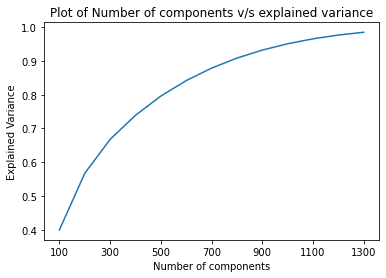

In [14]:
# ppmi-matrix
fit_data_ppmi = svd_fit(ppmi_matrix,step=100)
plt.plot(list(fit_data_ppmi), list(fit_data_ppmi.values()))
plt.xlabel('Number of components')
plt.xticks(list(fit_data_ppmi)[::2])
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [15]:
svd = TruncatedSVD(n_components=list(fit_data_ppmi.keys())[-1])
svd.fit(ppmi_matrix)
re_ppmi_matrix = svd.transform(ppmi_matrix)

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [16]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List, matrix) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list\n{corpus[i]}\n\n")
        
    return np.vstack(doc_vec), empty_doc_list

In [17]:
# co-occurrence matrix

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

print(f'{"train":=^50}')
doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list, re_co_matrix)
print(f'{"test":=^50}')
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list, re_co_matrix)

======================train=======================
document 611 doesn't contain word in vocab_list



document 798 doesn't contain word in vocab_list
ringtoneking


document 816 doesn't contain word in vocab_list
k k congratulation


document 910 doesn't contain word in vocab_list
beerage


document 1680 doesn't contain word in vocab_list
east coast


document 2043 doesn't contain word in vocab_list
audrie lousy autocorrect


document 2278 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 2303 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 2413 doesn't contain word in vocab_list



document 2650 doesn't contain word in vocab_list
u


document 2671 doesn't contain word in vocab_list
hanks lotsly


document 3552 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 3617 doesn't contain word in vocab_list



document 3686 doesn't contain word in vocab_list
g w r


===============

In [18]:
# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = knn.predict(doc_vec_test)

print(f"train acc by co-occurrence matrix: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"test acc by co-occurrence matrix:  {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc by co-occurrence matrix: 0.9725410758496511
test acc by co-occurrence matrix:  0.9685534591194969


In [19]:
# ppmi-matrix
print(f'{"train":=^50}')
doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list, re_ppmi_matrix)
print(f'{"test":=^50}')
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list, re_ppmi_matrix)

======================train=======================
document 611 doesn't contain word in vocab_list



document 798 doesn't contain word in vocab_list
ringtoneking


document 816 doesn't contain word in vocab_list
k k congratulation


document 910 doesn't contain word in vocab_list
beerage


document 1680 doesn't contain word in vocab_list
east coast


document 2043 doesn't contain word in vocab_list
audrie lousy autocorrect


document 2278 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford wheat chex


document 2303 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 2413 doesn't contain word in vocab_list



document 2650 doesn't contain word in vocab_list
u


document 2671 doesn't contain word in vocab_list
hanks lotsly


document 3552 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 3617 doesn't contain word in vocab_list



document 3686 doesn't contain word in vocab_list
g w r


===============

In [20]:
# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = knn.predict(doc_vec_test)

print(f"train acc by ppmi-matrix: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"test acc by ppmi-matrix:  {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc by ppmi-matrix: 0.9835696601395454
test acc by ppmi-matrix:  0.9784366576819407
